# Description

This notebook calculates flow transition rates using the method from Konya (2018). The first part reads in data from Eurostat, using the [pandaSDMX](https://www.google.com) package.

The second part calculates the flow rates. The idea is that every period there is a potential pool of searchers: those whose jobs just dissolved ($\rho E_{t-1}$), those who were unemployed ($U_{t-1}$) and those who were inactive ($I_{t-1}$). Out of this pool, $\lambda$ fraction searches for jobs. A fraction $f_t$ finds jobs within the period, the rest become unemployed.

The flow rates $\lambda_t$, $f_t$ and $\rho_t$ can be identified from job tenure data. The key equations are the following (from Kónya, 2018):
\begin{align}
\lambda_t f_t &= \frac{e_t^s}{1-e_{t-1}} \\
\rho_t &= \frac{1}{1-\lambda_t f_t} \left(1-\frac{e_t-e_{t-1}^s}{e_t}\right) \\
\lambda_t &= \frac{i_t}{\rho e_{t-1}+u_{t-1}+i_{t-1}}
\end{align}
The calculations rely on the data series read in the previous step.

# Get the data

In [1]:
# Query Eurostat
from pandasdmx import Request as rq
import matplotlib.pyplot as plt
estat = rq('ESTAT')

# Import metadata for the required datasets
meta1 = estat.datastructure('DSD_lfsq_ugan').write()
meta2 = estat.datastructure('DSD_lfsq_igan').write()
meta3 = estat.datastructure('DSD_lfsq_egdn2').write()
meta4 = estat.datastructure('DSD_lfsq_ugad').write()
meta5 = estat.datastructure('DSD_lfsi_long_q').write()
# meta1.codelist[:50]

In [2]:
# Total number of unemployed
resp1 = estat.data('lfsq_ugan', key={'FREQ': 'Q', 'SEX': 'T', 'AGE': 'Y15-64', 'CITIZEN': 'TOTAL'},params={'startPeriod': '2008'})
u = resp1.write()
u.columns = u.columns.get_level_values('GEO')
u = u.sort_index(ascending='True')

# Total number of inactive
resp2 = estat.data('lfsq_igan', key={'FREQ': 'Q', 'SEX': 'T', 'AGE': 'Y15-64', 'CITIZEN': 'TOTAL'},params={'startPeriod': '2007'})
inac = resp2.write()
inac.columns = inac.columns.get_level_values('GEO')
inac = inac.sort_index(ascending='True')

# Employed by duration: first long term, next short term, finally no response
resp3 = estat.data('lfsq_egdn2', key={'FREQ': 'Q', 'SEX': 'T', 'AGE': 'Y15-64','DURATION': 'M_GE3', 'NACE_R2': 'TOTAL'})
el = resp3.write()
el.columns = el.columns.get_level_values('GEO')
el = el.sort_index(ascending='True')
resp4 = estat.data('lfsq_egdn2', key={'FREQ': 'Q', 'SEX': 'T', 'AGE': 'Y15-64','DURATION': 'M_LT3', 'NACE_R2': 'TOTAL'})
es = resp4.write()
es.columns = el.columns.get_level_values('GEO')
es = es.sort_index(ascending='True')
resp5 = estat.data('lfsq_egdn2', key={'FREQ': 'Q', 'SEX': 'T', 'AGE': 'Y15-64','DURATION': 'NRP', 'NACE_R2': 'TOTAL'})
enr = resp5.write()
enr.columns = enr.columns.get_level_values('GEO')
enr = enr.sort_index(ascending='True')

# Unemployed by duration: first 1-2 month, next less than 1 month
resp6 = estat.data('lfsq_ugad', key={'FREQ': 'Q', 'SEX': 'T', 'AGE': 'Y15-64', 'DURATION': 'M1-2'},params={'startPeriod': '2008'})
us12 = resp6.write()
us12.columns = us12.columns.get_level_values('GEO')
us12 = us12.sort_index(ascending='True')
resp7 = estat.data('lfsq_ugad', key={'FREQ': 'Q', 'SEX': 'T', 'AGE': 'Y15-64', 'DURATION': 'M_LT1'},params={'startPeriod': '2008'})
usl1 = resp7.write()
usl1.columns = usl1.columns.get_level_values('GEO')
usl1 = usl1.sort_index(ascending='True')

# Gross flows data lfsi_long_q
flow = {}
for s in ['E_E','E_I','E_U','I_E','I_I','I_U','U_E','U_I','U_U']:
    resp = estat.data('lfsi_long_q', key={'FREQ': 'Q', 'UNIT': 'THS_PER', 'INDIC_EM': s, 'SEX': 'T'},params={'startPeriod': '2008'})
    flow[s] = resp.write()
    flow[s].columns = flow[s].columns.get_level_values('GEO')
    flow[s] = flow[s].sort_index(ascending='True')

# Calculate the rates

In [3]:
# Two state model
e = es+el
e = e.sort_index(ascending='True')
us = us12+usl1
us = us.sort_index(ascending='True')
em = e/(e+u)
em = em.sort_index(ascending='True')
ems = es/(e+u)
ems = ems.sort_index(ascending='True')
un = u/(e+u)
uns = us/(e+u)
fu = 1-(un.shift(-1)-uns.shift(-1))/un
rhou = (uns.shift(-1)/em)/(1-fu)
fe = ems.shift(-1)/un
rhoe = (1-(em.shift(-1)-ems.shift(-1))/em)/(1-fe)

# Three state model
pop = inac+e+u
inac = inac/pop
e = e/pop
es = es/pop
u = u/pop
lf = es.shift(-1)/(1-e)
rho = (1-(e.shift(-1)-es.shift(-1))/e)/(1-lf)
lamb = 1-inac.shift(-1)/((1-rho)*e)
f = lf/lamb
s = lamb*(1-(1-rho)*e)

# Rates from gross flow data
f_ue = flow['U_E']/(flow['U_U']+flow['U_E']+flow['U_I'])
rho_eui = (flow['E_U']+flow['E_I'])/(flow['E_E']+flow['E_U']+flow['E_I'])
lambda_gf = (flow['I_E']+flow['I_U'])/(flow['I_E']+flow['I_U']+flow['I_I'])

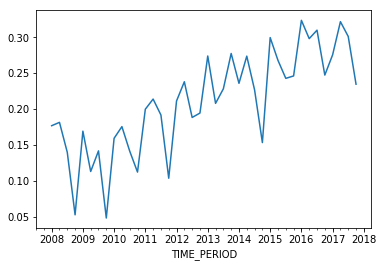

In [4]:
fu['HU'].plot(kind = 'line')